# Adding Libs

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community
import scipy.io
import pandas as pd
import random
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.mixture import GaussianMixture

## Initialization

In [2]:
connectomes = []
# list of humans with the type of Dictionary
# keys of Dictionary :
# type, name, conn_matrix, nodes_region

# Loading Data

In [3]:
files_path = "./UCLA_Autism/Autism_rsfmri/"
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(files_path) if isfile(join(files_path, f)) and f.find('connectivity_matrix')>=0]

In [4]:
def del_inf(conn_matrix):
    for i in range(len(conn_matrix)):
        conn_matrix[i][i] = 0        

In [5]:
for file_name in onlyfiles:
    fn = file_name[0:file_name.find('_rsfMRI_connectivity_matrix_file')]

       
    with open(join(files_path, file_name), 'r') as f:
        
        conn_matrix = [[float(num) for num in line.split()] for line in f]
    
    with open(join(files_path, fn + "_rsfMRI_region_names_abbrev_file.txt"), 'r') as f:
        nodes_region = [line.split()[0] for line in f]
    
    del_inf(conn_matrix)
    
    
    tmp_dict = {
        "type": "ASD" if fn.find('ASD')>=0 else "TD",
        "name": fn[3:] if fn.find('ASD')>=0 else fn[2:],
        "conn_matrix": np.array(conn_matrix),
        #"graph": np.array(conn_matrix>=0.3 + conn_matrix<=-0.3),
        "nodes_region": nodes_region
    }
    
    connectomes.append(tmp_dict)



# Feature Extraction

In [6]:
def get_all_node_strength(conn):
    
    A = nx.to_numpy_array(conn["graph"])
    G = np.multiply(A,conn["conn_matrix"])
    out = np.sum(G, axis=0)
    m = np.mean(out)
    v = np.var(out)
    out = (out-m)/v
    return np.array(out)


def get_all_eccentricity(conn):

    ecc = nx.algorithms.distance_measures.eccentricity(conn["graph"])
    out = np.array(list(ecc.values()))
    out = out/(conn["conn_matrix"].shape[0]-1)  
    return np.array(out)


def get_all_triangles(conn):
    
    out = np.array(list(nx.triangles(conn["graph"]).values()))
    n = conn["conn_matrix"].shape[0]
    out = out/((n-1)*(n-2)/2)
    return np.array(out)


def get_all_clustring(conn):
    
    out = np.array(list(nx.clustering(conn["graph"]).values()))    
    return np.array(out)

    
def get_all_degree_centrality(conn):
    
    out = np.array(list(nx.algorithms.centrality.degree_centrality(conn["graph"]).values()))    
    return np.array(out)


def get_all_closeness_centrality(conn):
    
    out = np.array(list(nx.algorithms.centrality.closeness_centrality(conn["graph"]).values()))   
    return np.array(out)


def get_all_betweenness_centrality(conn):
    
    out = np.array(list(nx.algorithms.centrality.betweenness_centrality(conn["graph"]).values())) 
    return np.array(out)


def get_all_eigenvector_centrality(conn):
    
    out = nx.algorithms.centrality.eigenvector_centrality(conn["graph"])
    out = np.array(list(out.values()))  
    return np.array(out)

In [7]:
def get_max_and_min(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3-q1
    maximum = np.max(data[(data <= (q3 + 1.5*iqr))])
    minimum = np.min(data[(data >= (q1 - 1.5*iqr))])
    return {'rmax':np.max(data),'rmin':np.min(data),'emax':q3,'emin':q1}


def get_summerized(data):
    
    out = data
    mm = get_max_and_min(out)    
    return np.array([mm['rmax'], mm['emax'], np.median(out), np.mean(out), mm['emin'], mm['rmin']])


def get_modularity(conn):
    communities_generator = community.girvan_newman(conn["graph"])
    top_level_communities = next(communities_generator)
    next_level_communities = next(communities_generator)
    comm = sorted(map(sorted, next_level_communities))
    
    return np.array(nx.algorithms.community.modularity(conn["graph"],comm))


def get_global_efficiency(conn):
    out = nx.algorithms.efficiency_measures.global_efficiency(conn["graph"])    
    return np.array(out)


def get_total_triangles(conn):
    
    out = conn["all_triangles"]
    n = conn["conn_matrix"].shape[0]
    out = np.sum(out)/(n*(n-1)*(n-2)/18)     
    return np.array(out)

In [8]:
j = 0.4
i = 0

for conn in connectomes:
    i = i+1
    conn["graph"]         = nx.from_numpy_matrix((conn["conn_matrix"] >= j)*1 + (conn["conn_matrix"] <= -j)*1)
    conn["all_node_strength"] = get_all_node_strength(conn)
    conn["all_eccentricity"]  = get_all_eccentricity(conn)
    conn["all_triangles"]     = get_all_triangles(conn)
    conn["all_clustring"]     = get_all_clustring(conn)
    conn["all_bet_cent"]      = get_all_betweenness_centrality(conn)
    conn["all_close_cent"]    = get_all_closeness_centrality(conn)
    conn["all_deg_cent"]      = get_all_degree_centrality(conn)
    conn["all_eig_cent"]      = get_all_eigenvector_centrality(conn)

    #print(i)

In [9]:
i = 0

for conn in connectomes:
    i = i+1
    conn["node_strength"] = get_summerized(conn["all_node_strength"])
    conn["eccentricity"]  = get_summerized(conn["all_eccentricity"])
    conn["triangles"]     = get_summerized(conn["all_triangles"])
    conn["clustring"]     = get_summerized(conn["all_clustring"])
    conn["bet_cent"]      = get_summerized(conn["all_bet_cent"])
    conn["close_cent"]    = get_summerized(conn["all_close_cent"])
    conn["deg_cent"]      = get_summerized(conn["all_deg_cent"])
    conn["eig_cent"]      = get_summerized(conn["all_eig_cent"])
    conn["glob_eff"]      = get_global_efficiency(conn)
    #print(i)

In [10]:
with open('modularity0-4.npy', 'rb') as f:
    for conn in connectomes :
        conn["modularity"] = np.load(f)

In [101]:
all_feat = []
feats_name = ["node_strength", "eccentricity", "triangles", "clustring", "bet_cent" \
             , "close_cent", "deg_cent", "eig_cent"]

for conn in connectomes:
    temp = []
    for feat_n in feats_name:
        temp.append(conn[feat_n].tolist())

    temp = np.array(temp)
    temp = np.append(temp, conn["modularity"])
    temp = np.append(temp, conn["glob_eff"])
    temp = temp.flatten()
    temp = temp[[12,13,14,15,16,18,19,20,21,22,25,26,27,28,30,31,32,33,34,36,37,38,39,40,49]]
    # [4,5,10,11,13,18,23]
    #temp = temp[[12,13,14,15,19,20,21,22,27,30,31,32,33,36,37,38,39,49]]
    all_feat.append(temp)    

In [102]:
features = np.array(all_feat)

In [103]:
features.shape

(79, 25)

# Clustering

## Agglomerative Clustering

In [105]:
ncl = 5
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=ncl, affinity='euclidean', linkage='ward')  
aggl = cluster.fit_predict(all_feat)
aggl

array([0, 0, 0, 1, 2, 2, 0, 0, 3, 0, 0, 2, 0, 0, 2, 4, 0, 2, 0, 2, 0, 2,
       2, 4, 3, 2, 0, 2, 2, 0, 0, 3, 2, 0, 0, 2, 2, 2, 1, 3, 0, 2, 2, 4,
       3, 1, 3, 1, 0, 2, 0, 0, 0, 2, 0, 0, 3, 2, 1, 4, 3, 0, 2, 2, 1, 1,
       4, 0, 1, 0, 3, 3, 2, 1, 3, 3, 0, 1, 0], dtype=int64)

In [106]:
l = aggl
i = 0
for i in range(ncl):
    x = np.sum((aggl== i)*1);
    c = 0
    for j in range(42):
        if aggl[j]==i:
            c+=1;
    print([x ,c ,x-c])

[29, 18, 11]
[10, 2, 8]
[23, 16, 7]
[12, 4, 8]
[5, 2, 3]


In [ ]:
labels = l
summ = 0
for i in range(ncl):
    s = np.sum(((labels==i)*1*tlabels0))
    ns = np.sum(((labels==i)*1*tlabels1))
    print(s, ns, s/(s+ns), ns/(s+ns), abs(s-ns)/(s+ns))
    summ += abs(s-ns)/(s+ns)
print(summ/ncl)

In [ ]:
xxxxxx = summ /ncl
print(summ)

In [ ]:
ncl = 5
summ = 0

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=ncl, random_state=0).fit(all_feat)
# gm.means_
labels = gm.predict(all_feat)
#print(labels)

for i in range(ncl):
    s = np.sum(((labels==i)*1*tlabels0))
    ns = np.sum(((labels==i)*1*tlabels1))
    print(s, ns, s/(s+ns), ns/(s+ns), abs(s-ns)/(s+ns))
    summ += abs(s-ns)/(s+ns)
summ/ncl
    
# 12 18 ... 13 6 ... 12 18 : all
# 16 24 ... 9  3 ... 12 15 : 0.05
# 15 18 ... 12 4 ... 10 20 : 0.025
# 14 23 ... 9  3 ... 14 16 : 0.02


# 9 15 ... 10 6 ... 10 17 ... 8 4 : all
# 13 16 ... 6 1 ... 8 15 ... 10 10 : 0.05
# 14 15 ... 6 1 ... 8 16 ... 9 10 :0.025
# 13 19 ... 6 1 ... 10 7 ... 8 15 : 0.02

# 7  12 ... 9 6 ... 10 14 ... 5 1  ... 6 9 :all
# 14 16 ... 6 1 ... 4 10  ... 7 4  ... 6 11 : 0.05
# 12 11 ... 6 1 ... 3 13  ... 7 4  ... 9 13 : 0.025
# 7  9  ... 4 1 ... 9 5   ... 7 15 ... 10 12 :0.2

# end Clustering

# Confusion

In [ ]:
tlabels = []
for conn in connectomes:
    tlabels.append(conn["type"])
tlabels0 = (np.array(tlabels)!='ASD')*1
tlabels1 = (np.array(tlabels)=='ASD')*1
tlabels = (np.array(tlabels)!='ASD')*1

print(tlabels)

In [ ]:
import confplot
columns = ["ASD", "TD"]
confplot.plot_confusion_matrix_from_data(
    tlabels,
    l,
    columns,
    
)

# ANOVA

In [119]:
feat_no = features.shape[1]

print(feat_no)

for j in range(feat_no):
    fea = features[:,j]
    people_frame = pd.DataFrame({"type" : labels , "triangles" : fea})
    groups = people_frame.groupby("type").groups
    g = []
    
    #print(j)
    for i in range(ncl):
        g.append(fea[groups[i]])


    num = stats.f_oneway(*g)[1]
    num_str = str(num).split('e')
    #if num<=0.05:
    #print(num)
    
    if num_str[0]=='nan':
        print(num)
    elif len(num_str)>1:
        print('{:.4f}'.format(float(num_str[0]))+'e'+num_str[1])
    else:
        print('{:.8f}'.format(float(num_str[0])))


25
2.2232e-32
1.8445e-31
1.2781e-23
7.2998e-32
1.4464e-11
2.2073e-15
2.1349e-29
2.7689e-30
5.0796e-31
1.4555e-24
4.4489e-17
1.2878e-15
1.0082e-25
7.5688e-11
4.7885e-31
2.9151e-33
2.3743e-21
3.9911e-28
4.7917e-09
9.5282e-31
1.4390e-33
2.1791e-22
6.9577e-30
7.1291e-10
1.2682e-28


In [ ]:
# Ordinary Least Squares (OLS) model


model = ols('node_strength ~ type', data=people_frame).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

# end ANOVA

# post-hoc

25
0


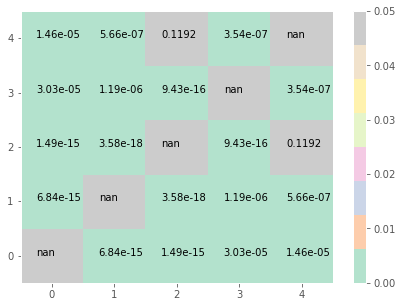

1


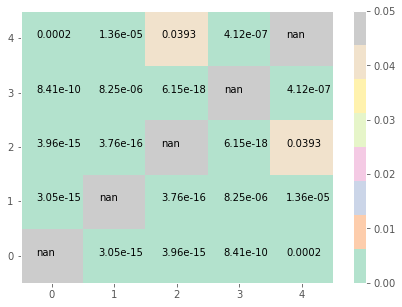

2


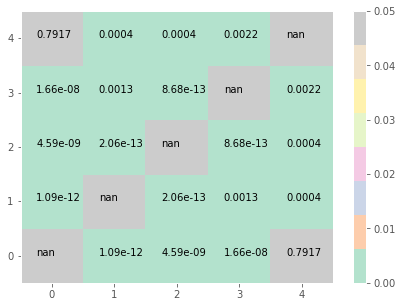

3


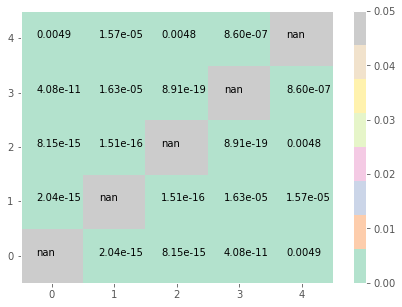

4


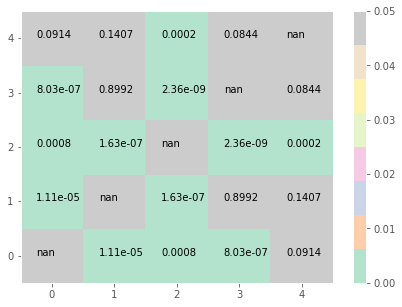

5


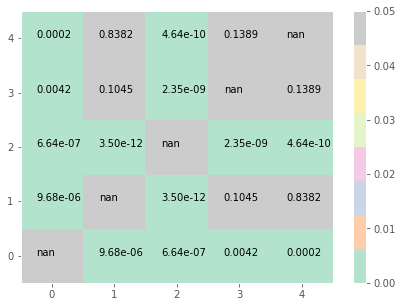

6


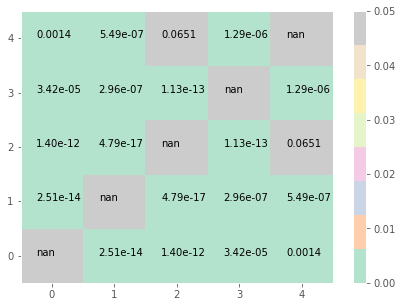

7


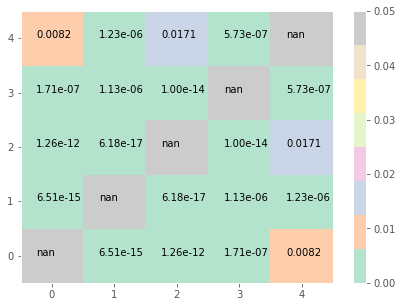

8


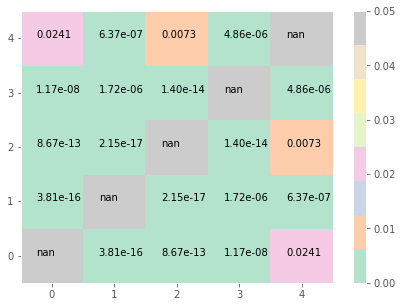

9


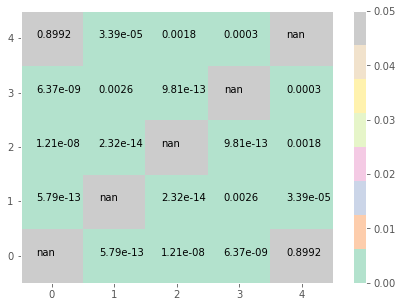

10


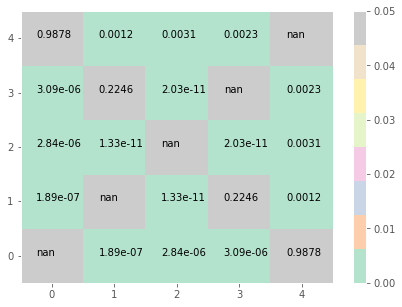

11


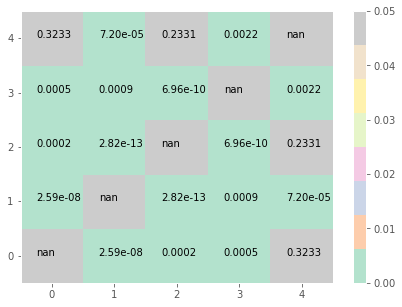

12


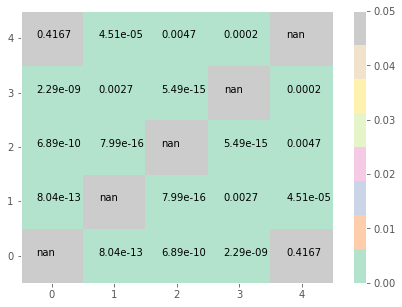

13


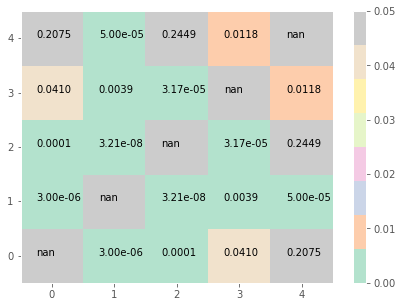

14


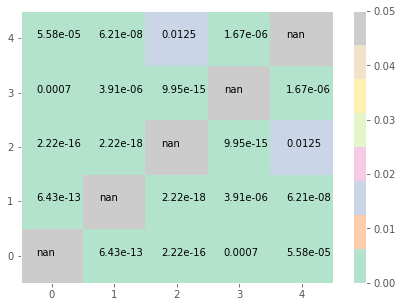

15


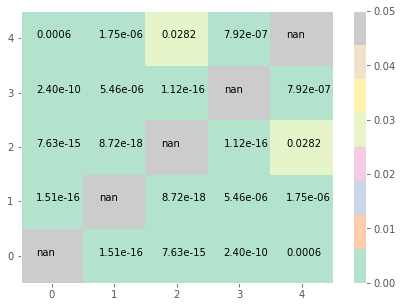

16


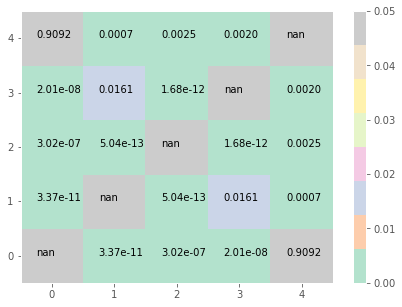

17


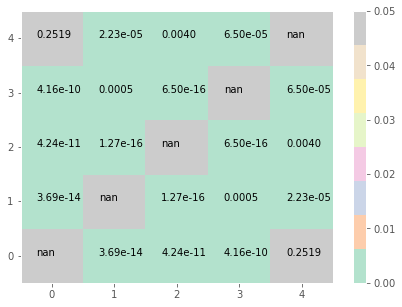

18


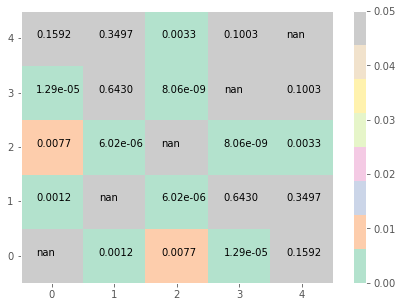

19


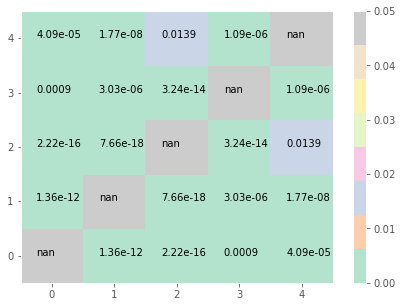

20


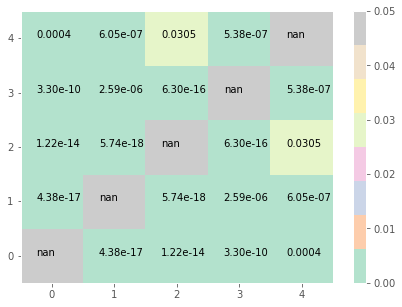

21


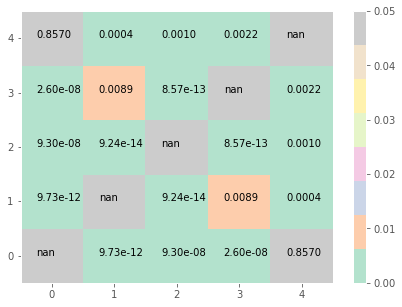

22


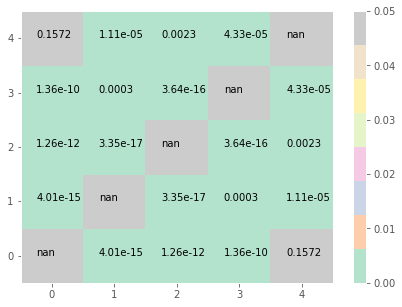

23


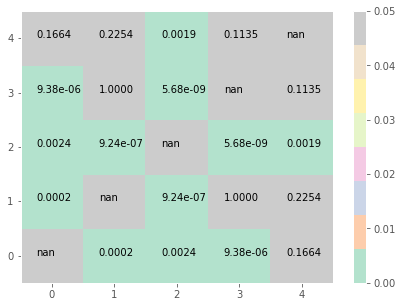

24


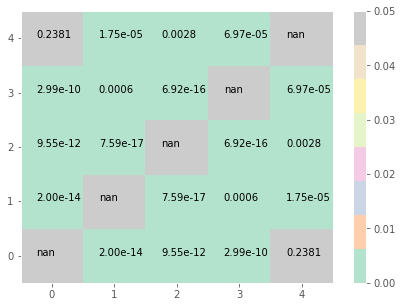

In [107]:
ncl = 5
cluster = AgglomerativeClustering(n_clusters=ncl, affinity='euclidean', linkage='ward')  
labels = cluster.fit_predict(all_feat)

fn = features.shape[1]
print(fn)
for item in range(fn) :
    print(item)
    feas = features[:,item]
    m = max(labels)+1
    mat = np.ones([m,m])
    for i in range(m):
        for j in range(i+1,m):
            l = np.array(((labels == i)*0 + (labels == j)*1))
            idx = np.array(((labels == i)*1 + (labels == j)*1)==1)
            l = l[idx]
            fea = feas[idx]
            people_frame = pd.DataFrame({"type" : l , "triangles" : fea})
            groups = people_frame.groupby("type").groups
            g = []

            for k in range(2):
                g.append(fea[groups[k]])


            num = stats.f_oneway(*g)[1]
            num_str = str(num).split('e')
            mat[i][j]=num
            mat[j][i]=num
    #print(mat,"\n ---->",np.max(mat))
    
    fig = plt.figure(figsize=(7,5))
    x = np.arange(0.5, 6, 1)  # len = 11
    y = np.arange(0.5, 6, 1)  # len = 7

    plt.pcolormesh(x-1,y-1,mat,cmap="Pastel2")
    #plt.title("Plot 2D array")
    plt.clim(0, 0.05)
    plt.colorbar()
    
    for a in range(ncl):
        for b in range(ncl):
            c = mat[b][a]
            num_str = str(c).split('e')
            if a==b:
                c = 'nan'
            elif len(num_str)>1:
                c = '{:.2f}'.format(float(num_str[0]))+'e'+num_str[1]
            else:
                c = '{:.4f}'.format(float(num_str[0]))
            plt.text(a-.25, b, str(c))
    plt.show()


# end post-hoc

# checking features in each cluster

In [ ]:
ncl = 5
cluster = AgglomerativeClustering(n_clusters=ncl, affinity='euclidean', linkage='ward')  
labels = cluster.fit_predict(all_feat)

tconn = np.array(connectomes)
tconn = tconn[(labels==3)]
a = np.array(conn["nodes_region"])
for conn in tconn:
    out = np.array(list(nx.triangles(conn["graph"]).values()))
    
    n = len(conn["all_close_cent"])
    x = np.array([i for i in range(n)])
    c2 = int(n/2)
    c1 = int(c2/2)
    c3 = c1 + c2
    
    sort0 = np.sort(conn["all_bet_cent"])
    sort1 = np.sort(conn["all_deg_cent"])
    idx0 = np.array((conn["all_bet_cent"] == sort0[-1]))#*1 + (conn["all_triangles"] == sort0[c3-1])*1 )
    idx1 = np.array((conn["all_deg_cent"] == sort1[-1]))#*1 + (conn["all_clustring"] == sort1[c3-1])*1 )
    out0 = out[((idx0==1)*1 + (idx0==2)*1) == 1]
    out1 = out[((idx1==1)*1 + (idx1==2)*1) == 1]
    #out = np.sum(out)
    print(out0,out1,x[((idx0==1)*1 + (idx0==2)*1) == 1],x[((idx1==1)*1 + (idx1==2)*1) == 1] \
         ,a[((idx0==1)*1 + (idx0==2)*1) == 1],a[((idx1==1)*1 + (idx1==2)*1) == 1])

# end cfiec

In [ ]:
import matplotlib.pyplot as plt


ncl = 5
cluster = AgglomerativeClustering(n_clusters=ncl, affinity='euclidean', linkage='ward')  
labels = cluster.fit_predict(all_feat)



fea = features[:,12]

# true_label
# labels
#n = len(connectomes[0]['all_triangles'])
#fea = np.array([connectomes[0]['all_triangles'], connectomes[2]['all_triangles']\
#                , connectomes[3]['all_triangles'], connectomes[4]['all_triangles']])
#ll = np.array([[0 for i in range(n)],[1 for i in range(n)],[2 for i in range(n)],[3 for i in range(n)]])


df = pd.DataFrame({"type" : labels, "fea" : fea})


bp = df.boxplot(column = 'fea', by = 'type', grid=True)

for i in range(ncl):
    y = df.fea[df.type==i].dropna()
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.5)




In [ ]:
#for conn in connectomes:
#conn = connectomes[0]
#tri_num = np.array(list(nx.triangles(conn["graph"]).values()))
#bet_cen = np.array(list(nx.betweenness_centrality(conn["graph"]).values()))
#deg_cen = np.array(list(nx.degree_centrality(conn["graph"]).values()))
for conn in connectomes:
    idx = np.array((conn["all_bet_cent"] == conn["bet_cent"][0]))
    a = np.array(conn["nodes_region"])
    print(a[idx])


#print(np.max(tri_num))
#tri_num*idx

In [ ]:
idx = (deg_cen == np.max(deg_cen))*1
idx

print(np.max(tri_num))
tri_num*idx

In [ ]:
# for test

mins = []
maxes = []
for i in range(len(connectomes)):
    mins.append(connectomes[i]['conn_matrix'].min())
    maxes.append(connectomes[i]['conn_matrix'].max())
    
print(min(mins))
print(max(maxes))

In [ ]:
with open('eccentricity.npy', 'wb') as f:
    for conn in connectomes :
        np.save(f, conn["eccentricity"])

In [ ]:
for conn in connectomes:
    n = len(conn["all_bet_cent"])
    x = np.array([i for i in range(n)])
    mm = get_max_and_min(conn["all_bet_cent"])
    idx1 = np.array((conn["all_bet_cent"] > mm['bmax']))
    '''
    idx5 = np.array((conn["all_bet_cent"] == conn["bet_cent"][0]))
    idx2 = np.array((conn["all_triangles"] == conn["triangles"][0]))
    idx3 = np.array((conn["all_deg_cent"] == conn["deg_cent"][0]))
    idx4 = np.array((conn["all_close_cent"] == conn["close_cent"][0]))
    '''
    nn1 = x[idx1]
    
    cys = nx.cycle_basis(conn["graph"])
    cys = [cy for cy in cys if len(cy)==3]
    
    xx = []
    for cy in cys:
        t = 0
        for nn in nn1:
            if nn in cy:
                t=1
        if t == 1:
            xx.append(cy)
    
    print(len(xx))


In [ ]:
at_least_one = np.array([])
every_three  = np.array([])
l1 = np.array([])

In [117]:

n = len(conn["all_close_cent"])
x = np.array([i for i in range(n)])
c2 = int(n/2)
c1 = int(c2/2)
c3 = c1 + c2


at_least_one = []
every_three  = np.array([])
l1 = []


def get_max(fea_n):
    sort0 = np.sort(conn[fea_n])
    idx0 = np.array((conn[fea_n] == sort0[-1])*1)
    idx0 = ((idx0==1)*1) == 1
    return idx0
    
def get_c3(fea_n):
    sort0 = np.sort(conn[fea_n])
    idx0 = np.array((conn[fea_n] == sort0[c3])*1 + (conn[fea_n] == sort0[c3-1])*1 )
    idx0 = ((idx0==1)*1 + (idx0==2)*1) == 1
    return idx0
    
def get_med(fea_n):
    sort0 = np.sort(conn[fea_n])
    idx0 = np.array((conn[fea_n] == sort0[c2])*1 + (conn[fea_n] == sort0[c2-1])*1 )
    idx0 = ((idx0==1)*1 + (idx0==2)*1) == 1
    return idx0

def get_c1(fea_n):
    sort0 = np.sort(conn[fea_n])
    idx0 = np.array((conn[fea_n] == sort0[c1])*1 + (conn[fea_n] == sort0[c1-1])*1 )
    idx0 = ((idx0==1)*1 + (idx0==2)*1) == 1
    return idx0





ncl = 5
cluster = AgglomerativeClustering(n_clusters=ncl, affinity='euclidean', linkage='ward')  
labels = cluster.fit_predict(all_feat)


for ln in range(ncl):

    

    tconn = np.array(connectomes)
    tconn = tconn[(labels==ln)]

    nnn = sum((labels==ln)*1)
    ttt = [ln for i in range(nnn)]
    l1.append(ttt)



    a = np.array(conn["nodes_region"])
    
    t_at_least_one = []
    
    for conn in tconn:
        nodes_r = np.array([])

        G_r = nx.from_numpy_matrix(nx.to_numpy_matrix(conn["graph"]))
        G_k = nx.from_numpy_matrix(nx.to_numpy_matrix(conn["graph"]))
        G = nx.from_numpy_matrix(nx.to_numpy_matrix(conn["graph"]))




        # clustring
        
        fea_n = "all_clustring"
        '''
        idx0 = get_max(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()
        
        idx0 = get_c3(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()
        '''
        
        idx0 = get_med(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()
        '''
        idx0 = get_c1(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()
        '''
        
        '''
        fea_n = "all_close_cent"
        
        
        idx0 = get_max(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()
        
        
        idx0 = get_c3(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()
        
        
        idx0 = get_med(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()
        
        idx0 = get_c1(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()
        
        fea_n = "all_deg_cent"
        
        idx0 = get_max(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()
        
        idx0 = get_c3(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()
        
        
        idx0 = get_med(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()
        
        
        idx0 = get_c1(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()
        '''
        
        '''
        fea_n = "all_bet_cent"
        
    
        idx0 = get_c3(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()


        idx0 = get_med(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()
        
        idx0 = get_c1(fea_n)
        nodes_r = np.append(nodes_r, x[idx0]).flatten()

        '''
        




        nodes_r = np.unique(nodes_r)[::-1]
        nodes_k = np.setdiff1d(x,nodes_r)




        for node in nodes_r:
            G_r.remove_node(node)

        for node in nodes_k:
            G_k.remove_node(node)


        out_r = np.array(list(nx.triangles(G_r).values()))
        out_k = np.array(list(nx.triangles(G_k).values()))
        out_t = np.array(list(nx.triangles(conn["graph"]).values()))

        n_r = len(nodes_r)
        #print((np.sum(out_t)/3 - np.sum(out_r)/3 )/(np.sum(out_t)/3),\
        #      np.sum(out_t)/3 - np.sum(out_r)/3,np.sum(out_k)/(3*n_r*(n_r-1)*(n_r-2)/6))

        t_at_least_one.append((np.sum(out_t)/3 - np.sum(out_r)/3 ))
        every_three =  np.append(every_three , np.sum(out_k) )
    at_least_one.append(t_at_least_one)

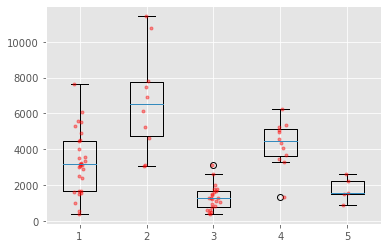

In [118]:
import matplotlib.pyplot as plt

plt.figure()

bp = plt.boxplot(at_least_one)

for i in range(ncl):
    y = at_least_one[i]
    x = np.random.normal(1+i, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.4)


In [ ]:
def intervall(ma,mi,me):
    m = len(ma)
    mat = np.zeros([m,m])
    for i in range(m):
        for j in range(i+1, ncl):
            
            if mi[i]>=ma[j] or ma[i]<=mi[j]:
                mat[i,j] = mat[j,i] = 1
                
            elif (me[i] >= ma[j] or me[i] <= mi[j]) and (me[j] >= ma[i] or me[j] <= mi[i]):
                mat[i,j] = mat[j,i] = 0.9
                
            elif (me[i] >= ma[j] or me[i] <= mi[j]) or (me[j] >= ma[i] or me[j] <= mi[i]):
                mat[i,j] = mat[j,i] = 0.8
                
            elif abs(me[i]-me[j])/(max(ma[i],ma[j])-min(mi[i],mi[j]))>=0.33:
                mat[i,j] = mat[j,i] = 0.7
            
            else:
                mat[i,j] = 0

    return mat


boxes = [boxes.get_ydata() for boxes in bp["boxes"]]
boxes = np.array(boxes)
medians = [medians.get_ydata() for medians in bp["medians"]]
medians = np.array(medians)
mat = intervall(boxes[:,3],boxes[:,1],medians[:,0])
            

fig = plt.figure(figsize=(7,5))
x = np.arange(0.5, 6, 1)  # len = 11
y = np.arange(0.5, 6, 1)  # len = 7
plt.pcolormesh(x-1,y-1,mat, cmap=plt.cm.get_cmap('Pastel1',20))
plt.colorbar()
plt.clim(0, 1)

for a in range(ncl):
    for b in range(ncl):
        c = mat[b][a]
        if c<0.33:
            c = ' '
        elif c==0.7:
            c = '   C'
        elif c==0.8:
            c = '   B'
        elif c==0.9:
            c = '  B+'
        elif c==1:
            c = '  A+'

        plt.text(a-.25, b, str(c))
       
 

In [ ]:
boxes = [boxes.get_ydata() for boxes in bp["boxes"]]
boxes = np.array(boxes)
medians = [medians.get_ydata() for medians in bp["medians"]]
medians = np.array(medians)
boxes


In [ ]:
mat = [[0,3,11,2,14],
       [3,0,6,0,12],
       [11,6,0,10,6],
       [2,0,10,0,10],
       [14, 12, 6, 10, 0]
      ]

x = np.arange(0.5, 6, 1)  # len = 11
y = np.arange(0.5, 6, 1)  # len = 7

plt.pcolormesh(x-1,y-1,mat,cmap="cividis")
plt.colorbar()
plt.clim(0, 24)

for a in range(ncl):
    for b in range(ncl):
        c = mat[b][a]
        if c==0:
            c = '0'
        elif c==0.7:
            c = 'C'
        elif c==0.8:
            c = 'B'
        elif c==0.9:
            c = 'B+'
        elif c==1:
            c = 'A+'

        plt.text(a-.25, b, str(c))
       

In [ ]:
maxx = 0
for conn in connectomes:
    print(conn["graph"])
    tmax1 = np.max(conn["graph"])
    print(tmax1)
    tmax2 = -np.min(conn["graph"])
    print(tmax1)
    tmin = min(tmax1,tmax2)
    maxx = min(tmin, maxx)
maxx 

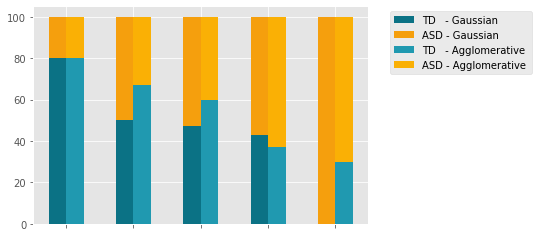

In [115]:
N = 5

'''
b_TD = (77,71,50,44)
b_ASD = (23,29,50,56)

a5_TD = (80,64,41,30)
a5_ASD = (20,36,59,70)

a2_TD = (86,69,54,39)
a2_ASD = (14,31,46,61)

b_TD = (71,42)
b_ASD = (29,58)

a5_TD = (80,42)
a5_ASD = (20,58)

a2_TD = (56,36)
a2_ASD = (44,64)

------

b_TD = (71,44,40)
b_ASD = (29,56,60)

a5_TD = (80,48,30)
a5_ASD = (20,52,70)

a2_TD = (86,50,36)
a2_ASD = (14,50,64)

-----
b_TD = (73,55,40,35)
b_ASD = (27,45,60,65)

a5_TD = (80,54,41,29)
a5_ASD = (20,46,59,71)
----
'''
b_TD = (80,50,47,43,0)
b_ASD = (20,50,53,57,100)

a5_TD = (80,67,60,37,30)
a5_ASD = (20,33,40,63,70)



ind = np.arange(N) 

width = 0.26    

plt.bar(ind, b_TD, width, label='TD   - Gaussian', color='#0B7285')
plt.bar(ind , b_ASD, width,label='ASD - Gaussian', bottom=b_TD, color='#F59F0D')

plt.bar(ind+width, a5_TD, width, label='TD   - Agglomerative ', color='#2099b0')
plt.bar(ind+width , a5_ASD, width,label='ASD - Agglomerative', bottom=a5_TD, color='#FAB005')

#plt.bar(ind+width+width, a2_TD, width, label='TD   - best ', color='#1daec4')
#plt.bar(ind+width+width , a2_ASD, width,label='ASD - best', bottom=a2_TD, color='#ffd575')


plt.xticks(ind+ width/2 , ())
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.pcolormesh(x-1,y-1)
plt.show()

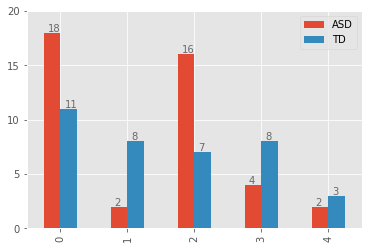

In [116]:
df = pd.DataFrame({'ASD': [18,2,16,4,2], 'TD': [11,8,7,8,3]}, index=['0', '1' , '2', '3','4'])
ax = df.plot.bar()

ax.set_alpha(0.7)
#ax.set_title("Where were the battles fought?", fontsize=18)
#ax.set_ylabel("Number of Battles", fontsize=18);
ax.set_yticks([0,5,10,15, 20])

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())


# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.06, i.get_height()+.12, \
            str(round((i.get_height()), 2)), fontsize=10,
                color='dimgrey')

In [67]:
np.random.rand(2)

array([0.88628406, 0.89066285])